# Code to train the RL agent

This code trains a PPO [stablebaseline3 RL-agent](https://github.com/DLR-RM/stable-baselines3) to learn an ideal policy to decide when to allow the student to use GenAI

## Imports

In [10]:
#imports 
from environment import LearningEnv     # your environment file
from gymnasium.envs.registration import register
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import psutil
psutil.virtual_memory()

svmem(total=16952647680, available=6583676928, percent=61.2, used=10368970752, free=6583676928)

## 1. Register the custom environment

In [11]:
register(
    id="MyEnv-v0",
    entry_point="environment:LearningEnv",
)

c:\Users\Janne\miniconda3-1\envs\Internship\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment MyEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## 2. Create and check the environment

In [12]:
env = gym.make("MyEnv-v0")
check_env(env)        #recommended by stable-baselines3 for custom envs
env = Monitor(env)    #logs rewards, episode lengths, etc.

## 3. Create PPO model

In [13]:
model = PPO(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    tensorboard_log="./ppo_logs/",   # tensorboard --logdir ppo_logs
)

Using cpu device
Wrapping the env in a DummyVecEnv.


## 4. Train the model

In [14]:
#!tensorboard --logdir ppo_logs --port 6006

In [ ]:
TIMESTEPS = 1_000_000
model.learn(total_timesteps=TIMESTEPS)

Logging to ./ppo_logs/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.44     |
|    ep_rew_mean     | -250     |
| time/              |          |
|    fps             | 2233     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 6.48        |
|    ep_rew_mean          | -246        |
| time/                   |             |
|    fps                  | 1456        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011725223 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | -0.00284    |
| 

## Print out a visual demonstration of the finally learned policy

The goal of this step is to make sure the environment does not simply always selects action 0

In [16]:
#Helper function to update a dictionary that keeps track of sums and counts for each position in lists
def update_position_sums(counter_dict, new_list):
    for i, val in enumerate(new_list):
        if i not in counter_dict:
            counter_dict[i] = [0, 0]  #[sum, count]
        counter_dict[i][0] += val
        counter_dict[i][1] += 1

Running episodes: 100%|██████████| 200/200 [00:13<00:00, 14.81it/s]


{0: [0, 200], 1: [0, 200], 2: [0, 200], 3: [0, 200], 4: [0, 200], 5: [0, 200], 6: [0, 200], 7: [0, 200], 8: [0, 200], 9: [0, 200], 10: [0, 200], 11: [0, 200], 12: [0, 200], 13: [0, 200], 14: [0, 200], 15: [0, 200], 16: [0, 200], 17: [0, 200], 18: [0, 200], 19: [0, 200], 20: [0, 200], 21: [0, 200], 22: [0, 200], 23: [0, 200], 24: [0, 200], 25: [0, 200], 26: [0, 200], 27: [0, 200], 28: [0, 200], 29: [0, 200], 30: [0, 200], 31: [0, 200], 32: [0, 200], 33: [0, 200], 34: [0, 200], 35: [0, 200], 36: [0, 200], 37: [0, 200], 38: [0, 200], 39: [0, 200], 40: [0, 200], 41: [0, 200], 42: [0, 200], 43: [0, 200], 44: [0, 200], 45: [0, 200], 46: [0, 200], 47: [0, 200], 48: [0, 200], 49: [0, 200], 50: [0, 200], 51: [0, 200], 52: [0, 200], 53: [0, 200], 54: [0, 200], 55: [0, 200], 56: [0, 200], 57: [0, 200], 58: [0, 200], 59: [0, 200], 60: [0, 200], 61: [0, 200], 62: [0, 200], 63: [0, 200], 64: [0, 200], 65: [0, 200], 66: [0, 200], 67: [0, 200], 68: [0, 200], 69: [0, 200], 70: [0, 200], 71: [0, 200], 7

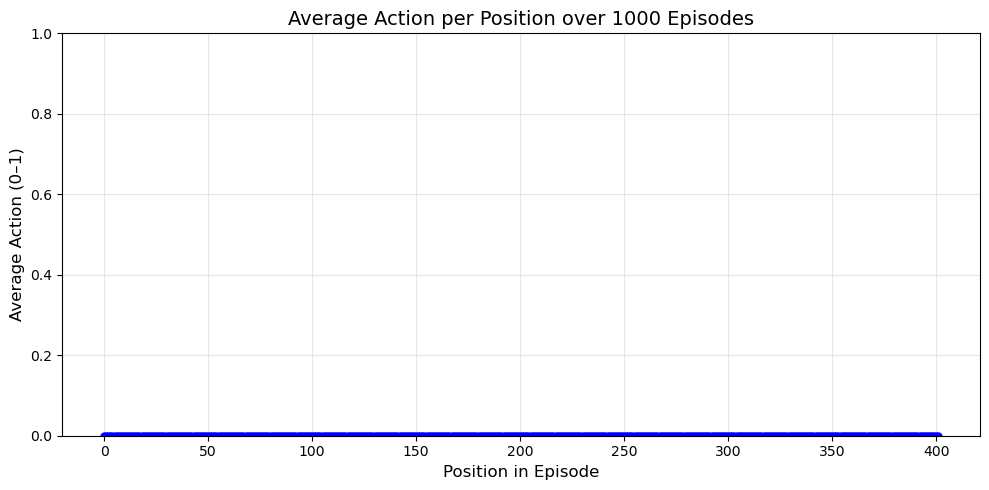

In [ ]:
env = gym.make("MyEnv-v0")

num_episodes = 200
action_means_dict = {}

for ep in tqdm(range(num_episodes), desc="Running episodes"):
    obs, _ = env.reset()
    actions = []
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=False) #works for deterministic = false
        action = int(np.squeeze(action)) #ensure it's 0 or 1
        actions.append(action)    
        obs, reward, terminated, truncated, info = env.step(action)
        if action == 1:
            print("AAAA")
        done = terminated or truncated

    update_position_sums(action_means_dict, actions)

print(action_means_dict)

# Calculate and print average actions per position
average_actions = {pos: action_means_dict[pos][0] / action_means_dict[pos][1] for pos in action_means_dict}

# Sort positions to plot them in order
positions = sorted(average_actions.keys())
means = [average_actions[pos] for pos in positions]

plt.figure(figsize=(10,5))
plt.plot(positions, means, marker='o', linestyle='-', linewidth=2, markersize=5, color='blue')
plt.ylim(0, 1)  # actions are binary, so mean is between 0 and 1
plt.xlabel("Position in Episode", fontsize=12)
#plt.ylim(0,0.001)
plt.ylabel("Average Action (0–1)", fontsize=12)
plt.title("Average Action per Position over 1000 Episodes", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

env.close()